In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import library as lip
%matplotlib inline

## Final Project Submission

* Student name: Ioana Preoteasa & Fadi Sarraf
* Student pace: full time
* Scheduled project review date/time: THU 12 Dec, 15.15
* Instructor name: Daniel Sanz
* Blog post URL: n/a


# What makes a successful song?
### Spotify Billboard Prediction and Analysis

### Table of contents
0. [Introduction](#0)
1. [Exploratory Data Analysis](#EDA)
2. [Data cleaning](#Data-Cleaning) 
3. [Model construction:](#Model)
    3.1 [Choice of models](#models)
    3.2 [Model performance on training](#training)
    3.3 [Testing our models](#testing)
4. [Conclusion](#Conclusion)

<a id='0'></a>
## 0. Introduction

What makes a song a hit? What factors drive a track to the greatest heights of success and fame? In this notebook and in our presentation we demonstrate how we reached a predictive model for song success. We used data from Spotify's API and the United States Billboard Hot 100 dataset and four different types of classifier models. 

Our project replicates and, we hope, improves on the work done by K Middlebrook and K Sheik  in their paper "Song Hit Prediction: Predicting Billboard Hits Using Spotify Data"* . However, we will be doing so in a much shorter amount of time (3 days) than the paper authors and with less computing power. 




*arXiv:1908.08609  

<a id='EDA'></a>
## 1. Exploratory Data Analysis

We began with a dataset of around 200'000 songs (including billboard hits and non-hits) and all the variables supplied through Spotify. After cleaning and balancing our dataset we still had 43'464 songs. Below is a list of all the variables in the data and their meaning. We removed the identifier data (track_id, track_name) and we later one-hot-encoded the artist_name and the genre. 

#### Data dictionary: 
* track_id: the song’s unique Spotify track ID

*  track_name: the track title

*  artist_name: the artist’s title

*  artist_id: the artist’s unique Spotify ID

*  popularity: a value between 0 and 100, with 100 being the most popular. Popularity is calculated by Spotify,
and is based, "in the most part, on the total number of plays the track has had and how recent those plays are"

*  explicit: a value indicated whether a track has explicit lyrics (1 = explicit, 0 = not explicit)

*  duration_ms: the duration of the track in milliseconds.

*  acousticness: a value from 0.0 to 1.0 predicting whether the track is acoustic.

*  danceability: a value from 0.0 to 1.0 describing how suitable a track is for dancing based on a combination of
musical elements including tempo, rhythm stability, beat strength, and overall regularity. Values closer to 1.0
indicate that the track is more danceable.

*  energy: a value from 0.0 to 1.0 that represents a perceptual measure of intensity and activity

*  instrumentalness: a value from 0.0 to 1.0 predicting whether the track is instrumental or contains vocals.
Values closer to 1.0 represent more instrumental track.

*  key: the key the track is in

*  liveness: a value from 0.0 to 1.0 that describes the presence of an audience in the track. Values closer to 1.0
represent tracks that were performed live.

*  loudness: the overall loudness of a track in decibels (dB)

*  mode: indicates the modality (major=1 or minor=0) of a track.

*  speechiness: a value from 0.0 to 1.0 describing the amount of spoken words present in the track. Values close
to 1.0 indicate exclusively speech-like tracks (e.g. podcast, audio book, poetry).

*  tempo: the overall estimated tempo of a track in beats per minute (BPM)

*  time_signature: an estimated overall time signature of a track.

*  valence: a value from 0.0 to 1.0 describing the musical positiveness conveyed by a track. A value close to 1.0
suggests that the track sounds more positive and upbeat.

*  weeks: a value indicating the total number of weeks the track was on the Billboard Hot 100 chart

*  peak position: a value between 0 and 100 indicating a track’s position on the Billboard Hot 100 chart. A value of 0 indicates that the track never appeared on the Billboard Hot 100 chart.

*  popularity: a weighted rank value from 0.0 to 1.0 indicating the popularity of a track. The score is a custom made
value. It is a weighted value indicating the most popular tracks on the Billboard Hot 100 chart. A value of 0.0
indicates the track never appeared on the chart. A value close to 1.0 indicates that the track appeared frequently
at the of the chart. Note, this value was not given to us, we used a data mining method, which was described
above, to calculate this value.

*  billboard_hit: indicates whether the track appeared on the Billboard Hot 100 chart (1=hit, 0=non-hit).

Although we are using a balanced data set, we decided not to use accuracy as our final metric so that our model is more generalizable to the kind of data our clients would be using, which will predominantly consist of non-hit songs. Given our client, we're using the Area Under a Curve for a receiver operating characteristic (ROC) curve. 

Below we've shown a subsection of our data (specifically our numerical variables), just to illustrate the noise and nature of the dataset. There are very few correlations or potential patterns detectable at this step, which only further justifies the use of classifiers. 


In [4]:
vis = pd.read_csv('vis_data.csv')
vis.groupby(by='billboard').mean()

,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,peak position,popularity,speechiness,tempo,time_signature,valence,weeks on chart
billboard,,,,,,,,,,,,,,,
0,0.602464,220226.950120,0.605714,0.110363,5.237944,0.184615,-7.97343,0.629625,0.000000,58.861541,0.100133,119.759084,3.902678,0.462669,0.000000
1,0.596905,222663.512976,0.620354,0.029845,5.244708,0.192710,-8.67765,0.729753,43.960749,41.577397,0.071022,120.237466,3.931391,0.603594,11.940318


Looking at the mean of all the numerical values above, there seems to be no significant difference between the hits and non-hits. When we plot the median values we observe much the same.

In [5]:
vis.groupby(by='billboard').median()

,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,peak position,popularity,speechiness,tempo,time_signature,valence,weeks on chart
billboard,,,,,,,,,,,,,,,
0,0.619,213496.5,0.637,0.000005,5.0,0.122,-6.5885,1.0,0,57.0,0.0530,119.9715,4.0,0.446,0
1,0.605,217266.0,0.637,0.000005,5.0,0.131,-8.2195,1.0,42,43.0,0.0408,118.7730,4.0,0.625,11


The noise within the data is illustrated best with a heatmap of the correlation matrix, shown below. Note that the billboard binary variable only correlates with "peak position" and "weeks on chart" because songs with 0 have values of 0 for those values. 

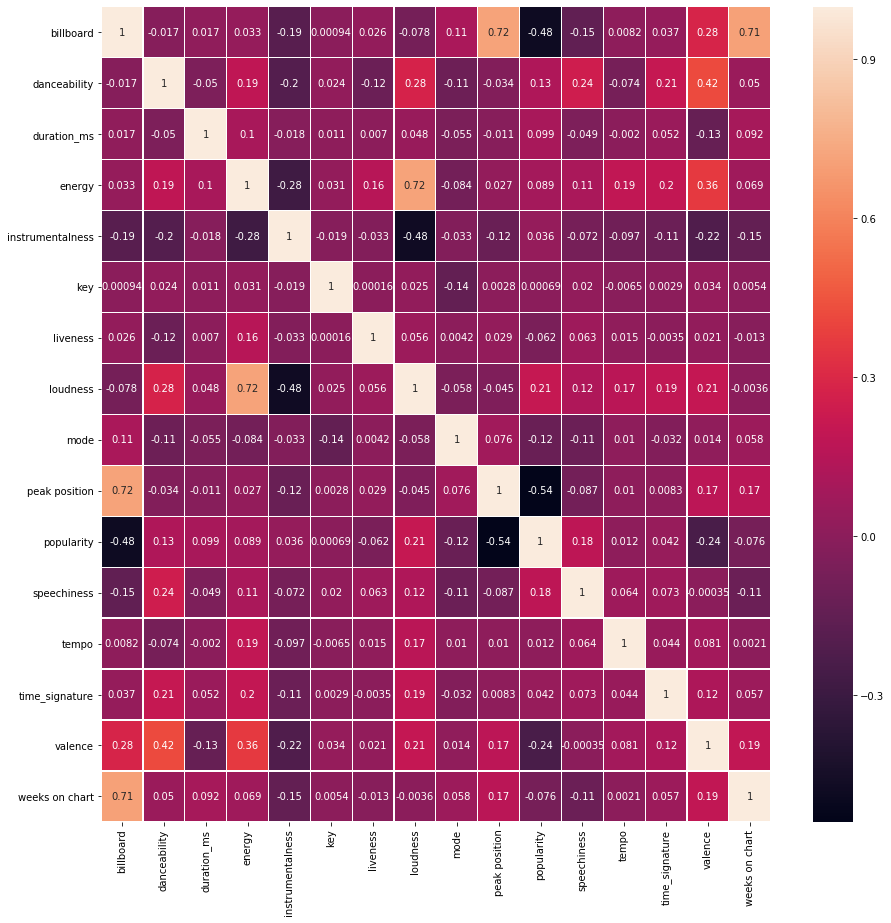

In [8]:
corrmat = vis.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(corrmat, annot=True, linewidths=0.2) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

The only pairs of variables that seem to be somewhat correlated are "energy" - "loudness" and "instrumentalness" - "loudness". We've plotted them below:

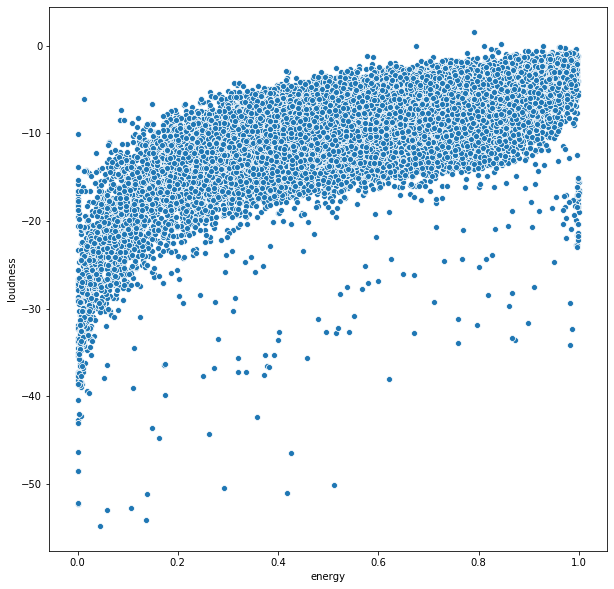

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(vis.energy, vis.loudness);

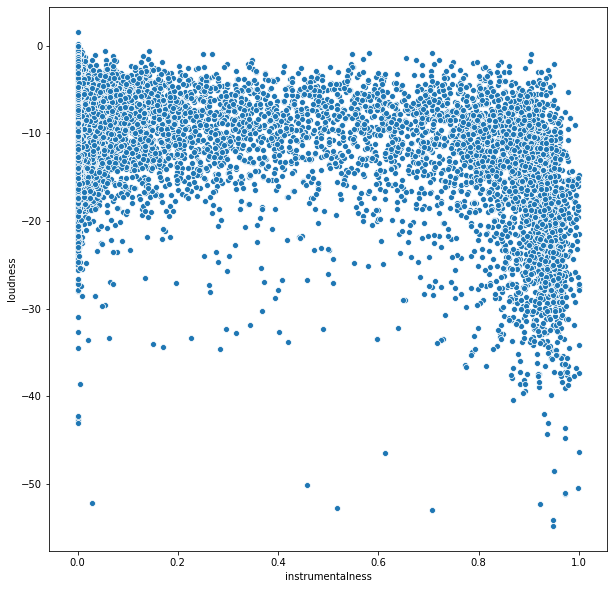

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(vis.instrumentalness, vis.loudness);

As can be observed, there is relatively little insight to be extracted from simple data exploration.

<a id='Data-Cleaning'></a>
## 2. Data Cleaning

To improve the interpretability of our final model success metric we used all the Billboard hit songs (  in number) and randomly sampled an equal amount from the non-hit dataset of songs. All of our categorical variables were turned to binary dummy variables. Song 'genre' was broken out into individual genres (of which there were 840) and then reclassified into 16 main genres. The list of primary genres and the identifying stems by which they were classified is available in the lib.py file in this repository. 




<a id='Model'></a>
## 3. Model Construction

In this section we present the four models we started with, our rationale for choosing them, results for all four and the process by which we further refined and improved our modelling. We will also be discussing our choice of evaluation metric, the ROC Area Under Curve. 

<a id='models'></a>
### 3.1 Choice of models

We  four classifiers: Logistic Regression, Decision Trees, K-Nearest Neighbours and Support Vector Classifier. Our target variable was 'billboard' (0 - song never made it on the billboard; 1 - song has appeared on the billboard). Our test data was 25% of our total and was scaled using ScikitLearn's MinMaxScaler. 



<a id='training'></a>
### 3.2 Model performances on training data

<a id='testing'></a>
### 3.3 Testing our models



Having chosen to use a Random Forest classifier with a 

<a id='Conclusion'></a>
## 4. Conclusion